# Setup

In [196]:
import sys  
sys.path.insert(0, '/home/ec2-user/SageMaker/efs/code/cad_llm')
import pandas as pd
import numpy as np
from pandas import DataFrame

In [ ]:
!pip install datasets torch transformers

# Load model and dataset

In [10]:
val_dataset_path = "/home/ec2-user/SageMaker/efs/data/sg_new_tkn_strings/sg_str_val.json"
all_ents_new_tokens_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/cad_llm_v1_all_ents_q_tkz_const_lr-02-17-23/checkpoint-265000"

In [5]:
from models.byt5 import get_byt5_model

tokenizer, model = get_byt5_model(all_ents_new_tokens_checkpoint)
model.to("cuda")
print("Done")

Done


In [6]:
quantize_n_bits = 6
def get_quantized_range(quantize_n_bits):
    return range(-2 ** (quantize_n_bits - 1), 2 ** (quantize_n_bits - 1))
tokenizer.add_tokens([f"<{i}>" for i in get_quantized_range(quantize_n_bits)])

64

In [12]:
from dataset.sg_dataset import SketchGraphsDataset, SketchGraphsCollator
from torch.utils.data import DataLoader

val_dataset = SketchGraphsDataset(val_dataset_path)
# val_dataset = SketchGraphsDataset(val_dataset_path, subset_range=[.2, .8])
data_collator = SketchGraphsCollator(tokenizer, max_length=128)

batch_size = 64
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)

# Evaluate

## Sample from model

In [ ]:
from tqdm import tqdm

all_samples = []
for batch in tqdm(val_dataloader):
    labels = batch["labels"].to("cuda")
    samples = model.generate(input_ids=batch["input_ids"].to("cuda"),
                             attention_mask=batch["attention_mask"].to("cuda"),
                             do_sample=False,
                             max_new_tokens=labels.shape[1])
    all_samples += samples

 25%|██▍       | 153/615 [02:32<07:43,  1.00s/it]

## Process samples

In [202]:
all_samples[0]

tensor([  0, 385, 407, 385, 419,  62, 435, 407, 435, 425,  62, 435, 425, 447,
        425,  62,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0], device='cuda:0')

In [46]:
def get_entities_from_sample(tokens):
    decoded = tokenizer.batch_decode([tokens], skip_special_tokens=True)[0]
    entities = [s.replace(" ", "") + ';' for s in decoded.split(';') if s]
    return entities

In [59]:
sketch = val_dataset.get_sketch(index=1)
len(sketch["entities"])

4

In [60]:
columns=["ent_count", "missing_ent_count", "percent_hidden", "sample_ent_count", "matching_ent_count"]
info = []
for i, sample in enumerate(tqdm(all_samples)):
    sketch = val_dataset.get_sketch(index=i)
    label_ents = set([ent for j, ent in enumerate(sketch["entities"]) if not sketch["mask"][j]])
    sample_ents = set(get_entities_from_sample(sample))
    intersection = sample_ents.intersection(label_ents)

    info.append([
        len(sketch["entities"]), 
        len(label_ents),
        len(label_ents) / len(sketch["entities"]),
        len(sample_ents),
        len(intersection),
    ])
    
df = pd.DataFrame(info, columns=columns)

100%|██████████| 39344/39344 [04:40<00:00, 140.43it/s]


In [96]:
df["percent_autocompleted"] = df.matching_ent_count / df.missing_ent_count
df["percent_useful"] = df.matching_ent_count / df.sample_ent_count
df["any_autocompleted"] = (df.matching_ent_count >= 1)
df["all_autocompleted"] = (df.matching_ent_count == df.missing_ent_count)
df["exact_match"] = (df.matching_ent_count == df.missing_ent_count) & (df.sample_ent_count == df.missing_ent_count)
df["bucket_percent_hidden"] = df.percent_hidden.round(decimals=1)

In [62]:
df.describe()

,ent_count,missing_ent_count,percent_hidden,sample_ent_count,matching_ent_count,percent_autocompleted,percent_useful,bucket_percent_hidden
count,39344.000000,39344.000000,39344.000000,39344.000000,39344.000000,39344.000000,39344.000000,39344.000000
mean,7.752745,3.856954,0.497882,3.324014,1.273256,0.424702,0.412894,0.497606
std,3.365669,2.709006,0.236449,1.738645,1.386160,0.410251,0.392107,0.247334
min,2.000000,1.000000,0.062500,1.000000,0.000000,0.000000,0.000000,0.100000
25%,5.000000,2.000000,0.285714,2.000000,0.000000,0.000000,0.000000,0.300000
50%,7.000000,3.000000,0.500000,3.000000,1.000000,0.333333,0.333333,0.500000
75%,10.000000,5.000000,0.700000,4.000000,2.000000,1.000000,0.750000,0.700000
max,16.000000,15.000000,0.937500,15.000000,12.000000,1.000000,1.000000,0.900000


In [63]:
df.head()

,ent_count,missing_ent_count,percent_hidden,sample_ent_count,matching_ent_count,percent_autocompleted,percent_useful,any_autocompleted,all_autocompleted,exact_match,bucket_percent_hidden
0,8,3,0.375000,3,1,0.333333,0.333333,True,False,False,0.4
1,4,2,0.500000,4,2,1.000000,0.500000,True,True,False,0.5
2,3,1,0.333333,1,0,0.000000,0.000000,False,False,False,0.3
3,16,13,0.812500,5,1,0.076923,0.200000,True,False,False,0.8
4,2,1,0.500000,3,1,1.000000,0.333333,True,True,False,0.5


# Visualize

In [195]:
print("summary")
print(f"all_autocompleted: {df.all_autocompleted.mean()*100:.2f}%")
print(f"any_autocompleted: {df.any_autocompleted.mean()*100:.2f}%")
print(f"percent_autocompleted: {df.percent_autocompleted.mean()*100:.2f}%")
print(f"percent_useful: {df.percent_useful.mean()*100:.2f}%")
print(f"exact_match: {df.exact_match.mean()*100:.2f}%")

summary
all_autocompleted: 27.64%
any_autocompleted: 65.01%
percent_autocompleted: 42.47%
percent_useful: 41.29%
exact_match: 17.64%


## Data distribution

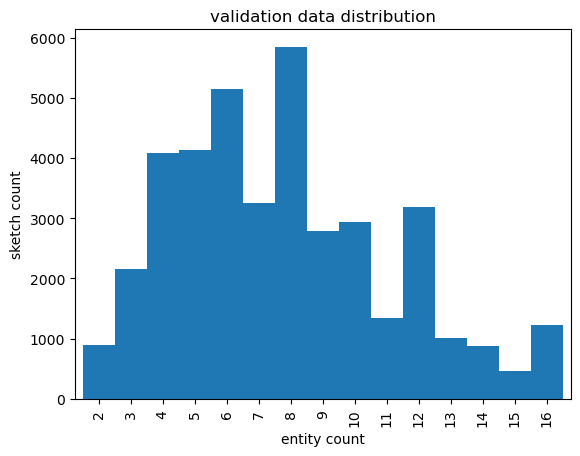

In [102]:
_ = df.groupby("ent_count").size().plot.bar(title="validation data distribution", xlabel="entity count", ylabel="sketch count", width=1.0)

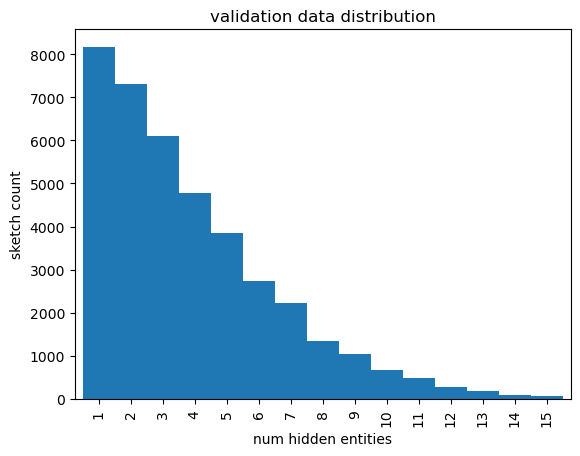

In [105]:
_ = df.groupby("missing_ent_count").size().plot.bar(title="validation data distribution", xlabel="num hidden entities", ylabel="sketch count", width=1.0)

In [110]:
np.round(0.25, decimals=1)

0.2

In [109]:
np.round(0.75, decimals=1)

0.8

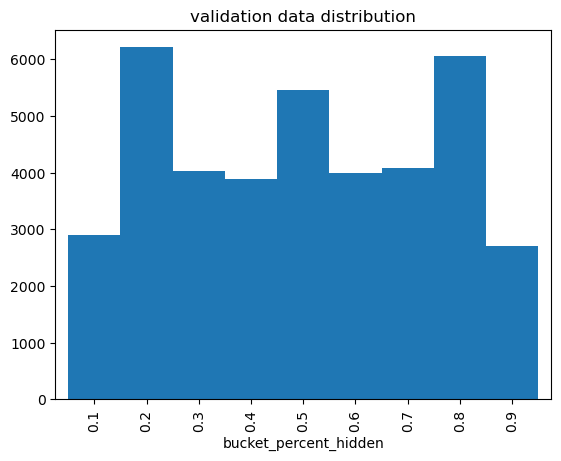

In [200]:
_ = df.groupby("bucket_percent_hidden").size().plot.bar(title="validation data distribution", width=1.0)

## Full autocomplete

all_autocompleted mean (weighted): 0.28


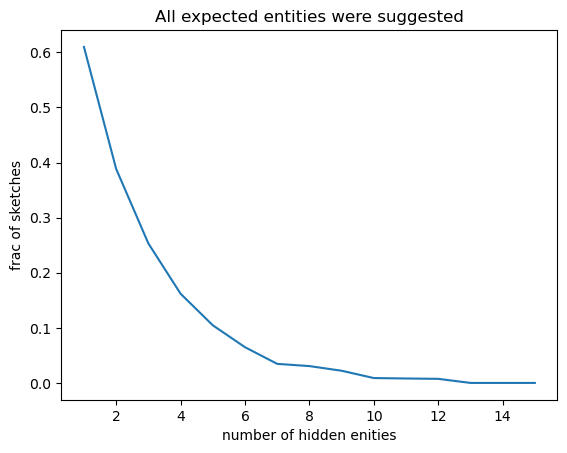

In [121]:
_ = df.groupby("missing_ent_count").all_autocompleted.mean().plot(title="All expected entities were suggested",
                                                                  xlabel="number of hidden enities", ylabel="frac of sketches")
print(f"all_autocompleted mean (weighted): {df.all_autocompleted.mean():.2}")

In [122]:
# _ = df[df.bucket_percent_hidden > 0.8].groupby("missing_ent_count").any_autocompleted.mean().plot(title="All expected entities were suggested", xlabel="number of hidden enities")
# print(f"any_autocompleted mean (weighted): {df[df.bucket_percent_hidden > 0.8].any_autocompleted.mean():.2}")

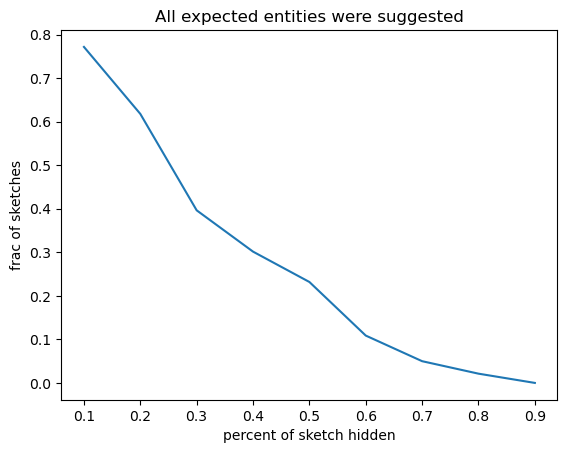

In [125]:
_ = df.groupby("bucket_percent_hidden").all_autocompleted.mean().plot(title="All expected entities were suggested", 
                                                                      xlabel="percent of sketch hidden", ylabel="frac of sketches")

mean (weighted): 0.65


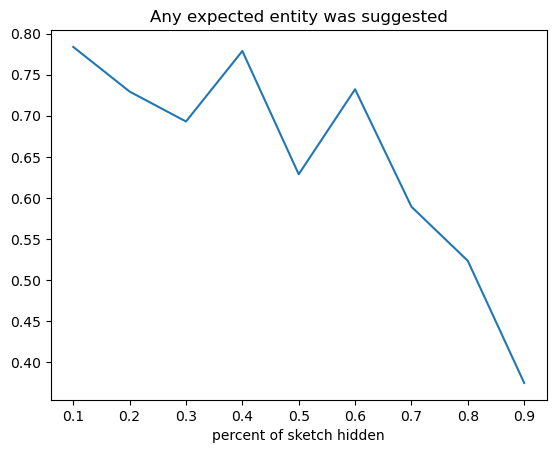

In [201]:
_ = df.groupby("bucket_percent_hidden").any_autocompleted.mean().plot(title="Any expected entity was suggested", xlabel="percent of sketch hidden")
print(f"mean (weighted): {df.any_autocompleted.mean():.2}")

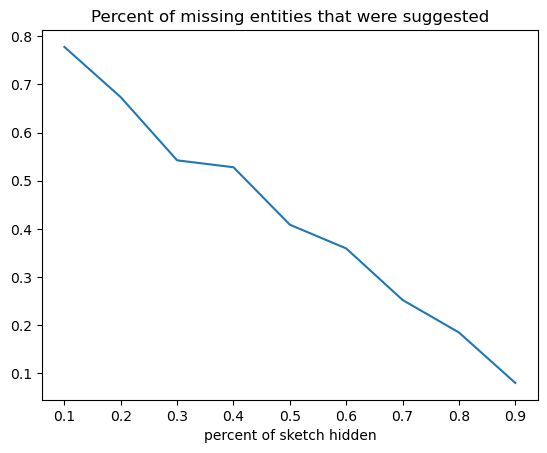

In [203]:
_ = df.groupby("bucket_percent_hidden").percent_autocompleted.mean().plot(title="Percent of missing entities that were suggested", xlabel="percent of sketch hidden")

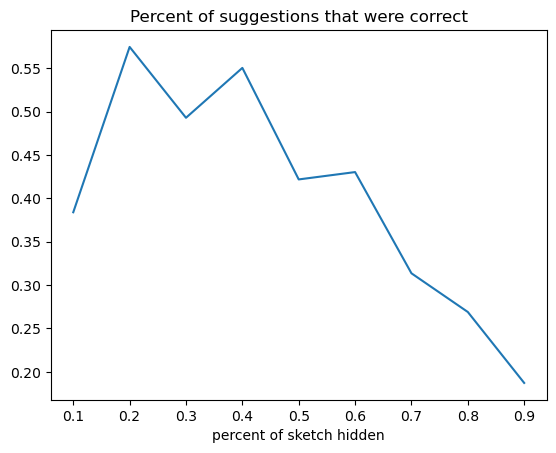

In [204]:
_ = df.groupby("bucket_percent_hidden").percent_useful.mean().plot(title="Percent of suggestions that were correct", xlabel="percent of sketch hidden")

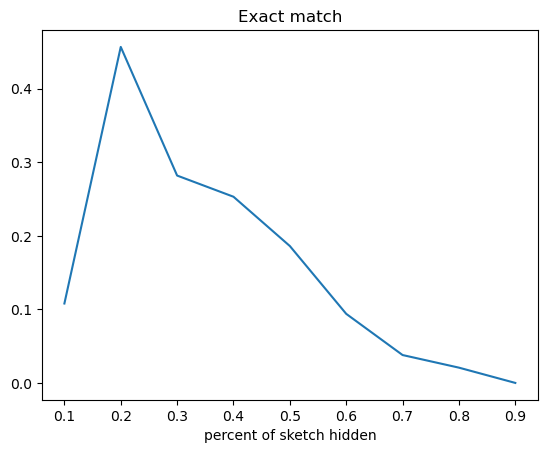

In [205]:
_ = df.groupby("bucket_percent_hidden").exact_match.mean().plot(title="Exact match", xlabel="percent of sketch hidden")

# Data heatmap

In [126]:
all_data = val_dataset.data

In [129]:
all_enitites = [sketch["entities"] for sketch in all_data]

In [177]:
heatmap = np.zeros(shape=(64, 64), dtype=int)

for sketch in tqdm(all_data):
    entities = sketch["entities"]
    for ent in entities:
        ent = ent[1:-2]  # remove "<" from begining and ">;" from end
        num_strings = ent.split("><")

        for i in range(0, len(num_strings), 2):
            point = int(num_strings[i]) + 31, int(num_strings[i + 1]) + 31
            heatmap[point] += 1

100%|██████████| 39344/39344 [00:00<00:00, 46526.26it/s]


In [ ]:
heatmap

In [207]:
heatmap.sum()

680621

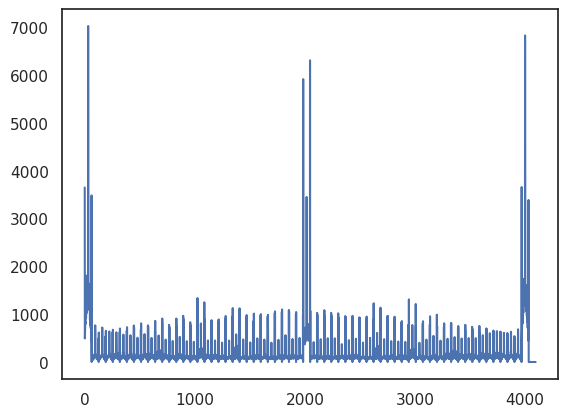

In [192]:
flat_heatmap = heatmap.reshape(-1)
pd.Series(flat_heatmap).plot()
print()

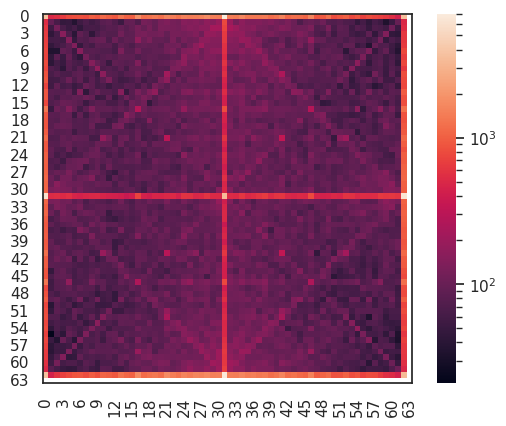

In [187]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import seaborn as sns; sns.set_theme(style='white')

ax = sns.heatmap(heatmap, square=True, norm=LogNorm())
for _, spine in ax.spines.items():
    spine.set_visible(True)
    
print()

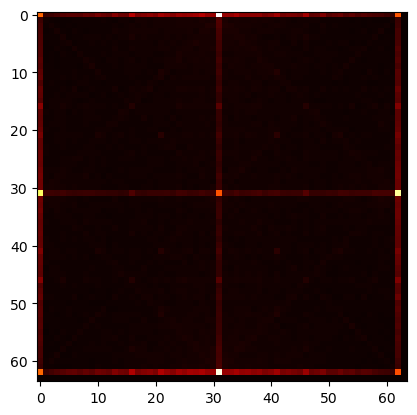

In [181]:
import matplotlib.pyplot as plt
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.show()